In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType
from pyspark.sql.functions import col, year, hour, to_timestamp, desc, count

**1.Create a Spark session**

In [2]:
#Creating a Spark session
spark = SparkSession.builder.appName("ChicagoCrimeDataInvestigation").getOrCreate()

**2.Define the schema for loading the Chicago crime dataset (https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2/data).**

In [3]:
#Defining the schema
crime_data_schema = StructType([
    StructField("ID", StringType(), True),
    StructField("Case Number", StringType(), True),
    StructField("Date", StringType(), True),
    StructField("Block", StringType(), True),
    StructField("IUCR", StringType(), True),
    StructField("Primary Type", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Location Description", StringType(), True),
    StructField("Arrest", StringType(), True),
    StructField("Domestic", StringType(), True),
    StructField("Beat", StringType(), True),
    StructField("District", StringType(), True),
    StructField("Ward", StringType(), True),
    StructField("Community Area", StringType(), True),
    StructField("FBI Code", StringType(), True),
    StructField("X Coordinate", StringType(), True),
    StructField("Y Coordinate", StringType(), True),
    StructField("Year", IntegerType(), True),
    StructField("Updated On", StringType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Location", StringType(), True)
])

**3.Load the Chicago crime data (you should get more than a million rows).**

In [4]:
#Loading the data
df = spark.read.csv("/content/Crimes_-_2001_to_Present_20250404.csv", header=True, schema=crime_data_schema)
df.count()

8287103

In [5]:
#printing the dataframe schema
df.printSchema()


root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [6]:
df.show()

+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|13311263|   JG503434|07/29/2022 03:39:...|     023XX S TROY ST|1582|OFFENSE INVOLVING...|   CHILD PORNOGRAPHY|           RE

**4.Clean the data:**
    
    a. Remove all null values.

    b.Change 'Date' column data type

In [7]:
#a.Cleaning the data
df = df.dropna()

In [8]:
#b.changing date column data type
df = df.withColumn("Date", to_timestamp("Date", "MM/dd/yyyy hh:mm:ss a"))
print("After converting to timestamp:")
df.select("Date").show(5, truncate=False)
df.printSchema()

After converting to timestamp:
+-------------------+
|Date               |
+-------------------+
|2023-09-06 17:00:00|
|2023-09-06 11:00:00|
|2019-05-21 08:20:00|
|2021-07-07 10:30:00|
|2022-06-14 14:47:00|
+-------------------+
only showing top 5 rows

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated

**5.Filter the data for last ten years.**

In [9]:
df = df.filter(year("Date") >= 2016)


**6.Remove all the records with the following crime types:**

    'NON-CRIMINAL (SUBJECT SPECIFIED)'
    'OTHER OFFENSE'
    'STALKING'
    'NON - CRIMINAL'
    'ARSON'

In [10]:
excluded = ['NON-CRIMINAL (SUBJECT SPECIFIED)', 'OTHER OFFENSE', 'STALKING', 'NON - CRIMINAL', 'ARSON']
df = df.filter(~col("Primary Type").isin(excluded))



**Merge the similar crime types.**

For example, change 'Primary Type' of cases that have 'Primary Type' as ‘SEX OFFENSE’ or ‘PROSTITUTION’ such that they should have the same 'Primary Type'.

In [11]:
from pyspark.sql.functions import when

df = df.withColumn(
    "Primary Type",
    when(col("Primary Type").isin("SEX OFFENSE", "PROSTITUTION"), "SEXUAL RELATED")
    .otherwise(col("Primary Type"))
)


In [12]:
df.select("Primary Type").distinct().orderBy("Primary Type").show(truncate=False)


+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON-CRIMINAL                     |
|OBSCENITY                        |
+---------------------------------+
only showing top 20 rows



**Analyze the data and present results:**

    Show year-wise trend of the crime for last ten years.
    Find out at which hour of the day crime is highest.
    Find top ten crimes and present them as a bar chart.

In [13]:
#Year-wise trend of the crime
df.groupBy(year("Date").alias("Year")).count().orderBy("Year").show()

+----+------+
|Year| count|
+----+------+
|2016|248599|
|2017|246574|
|2018|245390|
|2019|240853|
|2020|193877|
|2021|187558|
|2022|219017|
|2023|243254|
|2024|238728|
|2025| 45695|
+----+------+



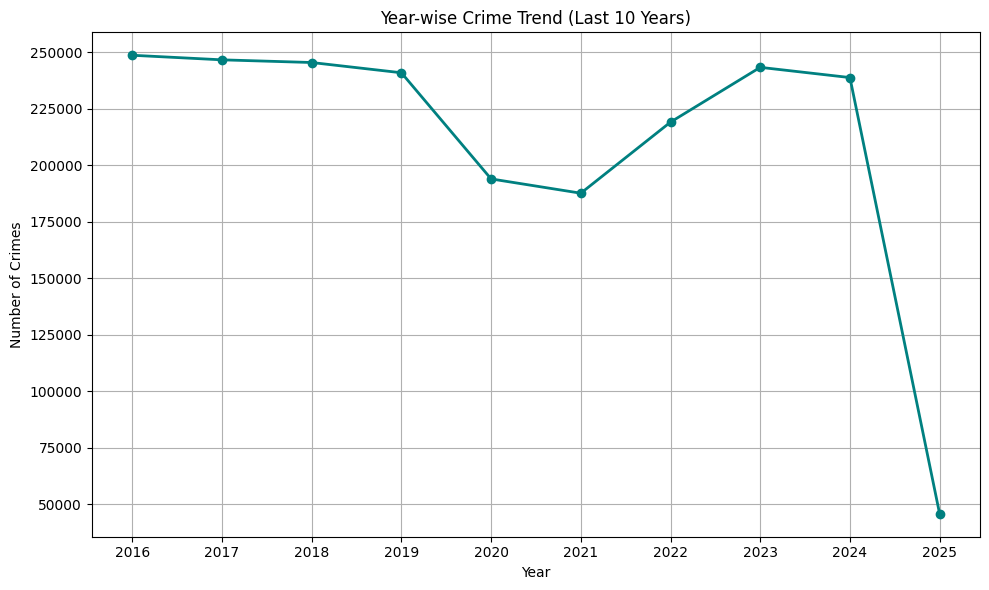

In [15]:
from pyspark.sql.functions import year
import matplotlib.pyplot as plt

# Grouping and converting to Pandas
yearly_trend_df = df.groupBy(year("Date").alias("Year")).count().orderBy("Year").toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(yearly_trend_df["Year"], yearly_trend_df["count"],color='teal', marker='o', linestyle='-', linewidth=2)
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.title("Year-wise Crime Trend (Last 10 Years)")
plt.grid(True)
plt.xticks(yearly_trend_df["Year"])  # Ensures all years are visible
plt.tight_layout()
plt.show()

In [16]:
#Most frequent hour of crime
df.withColumn("Hour", hour("Date")).groupBy("Hour").count().orderBy(desc("count")).show(1)

+----+------+
|Hour| count|
+----+------+
|   0|124704|
+----+------+
only showing top 1 row



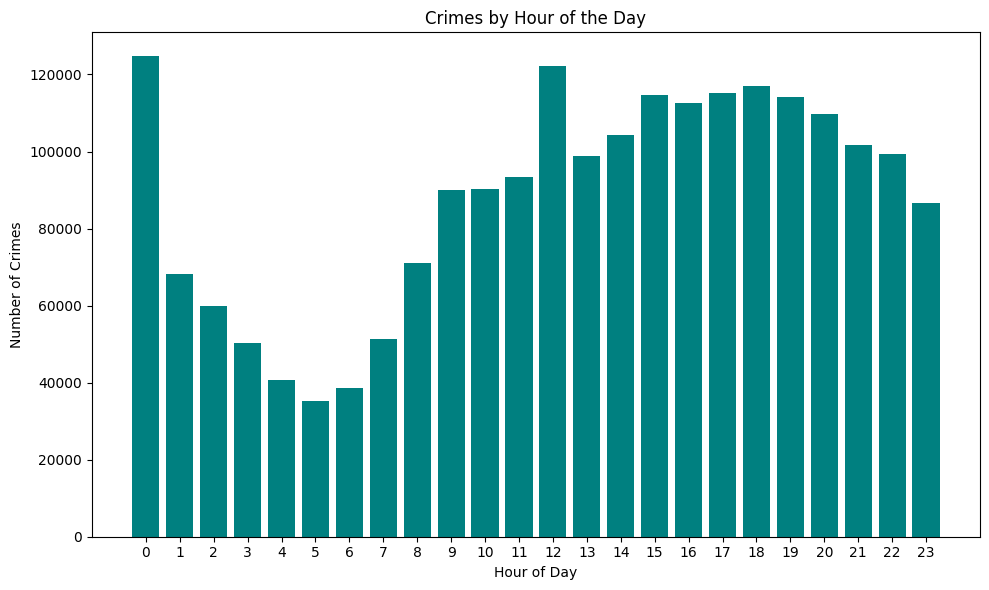

In [17]:
from pyspark.sql.functions import hour

# Extracting hour and group
hourly_df = df.withColumn("Hour", hour("Date")).groupBy("Hour").count().orderBy("Hour").toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(hourly_df["Hour"], hourly_df["count"],color='teal')
plt.xlabel("Hour of Day")
plt.ylabel("Number of Crimes")
plt.title("Crimes by Hour of the Day")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


In [18]:
#Top 10 crimes
top_crimes = df.groupBy("Primary Type").count().orderBy(desc("count")).limit(10)
top_crimes.show()

+-------------------+------+
|       Primary Type| count|
+-------------------+------+
|              THEFT|512563|
|            BATTERY|419773|
|    CRIMINAL DAMAGE|254310|
|            ASSAULT|188431|
| DECEPTIVE PRACTICE|147632|
|MOTOR VEHICLE THEFT|137636|
|           BURGLARY| 88798|
|            ROBBERY| 87627|
|          NARCOTICS| 81234|
|  WEAPONS VIOLATION| 63718|
+-------------------+------+



<ipython-input-25-ca940575eaba>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Blues")


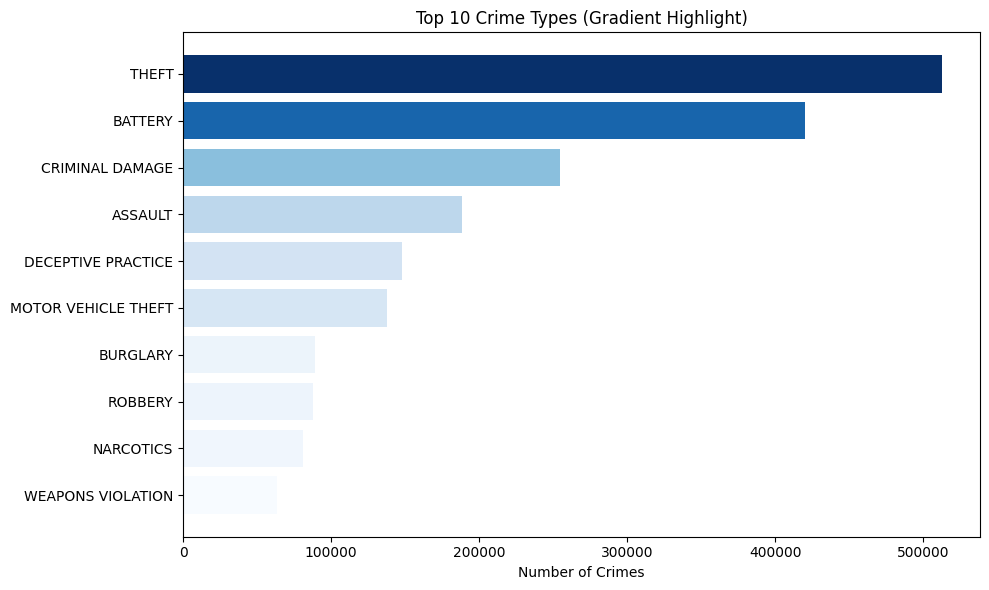

In [25]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import desc

top_crimes_df = df.groupBy("Primary Type").count().orderBy(desc("count")).limit(10).toPandas()

# Sorting for better display
top_crimes_df = top_crimes_df.sort_values("count", ascending=True)


import numpy as np



# Normalize the count values between 0 and 1
norm = (top_crimes_df["count"] - top_crimes_df["count"].min()) / \
       (top_crimes_df["count"].max() - top_crimes_df["count"].min())

# Map normalized values to a colormap (e.g., 'Blues')
from matplotlib.cm import get_cmap
cmap = get_cmap("Blues")
bar_colors = [cmap(x) for x in norm]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_crimes_df["Primary Type"], top_crimes_df["count"], color=bar_colors)
plt.xlabel("Number of Crimes")
plt.title("Top 10 Crime Types (Gradient Highlight)")
plt.tight_layout()
plt.show()
